<a href="https://colab.research.google.com/github/fweilun/momentum/blob/main/trend_following.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trend Following
trend following is mainly contains of two parts. The first one is the signal and the other is the stock position according to the signal.

#Signal
We define the signal of a trend by using volatility-adjusted price change which is weighted by exponential moving averge.

we define $⟨p⟩_{n,t}$ as exponential moving average of past prices.

The signal $S_n(t)$ at the beginning of month t is constructed as

$$S_n(t)=\frac{p(t-1)-⟨p⟩_{n,t-1}}{σ_n(t − 1)}$$

The volatility $σ_n$ is equal to the exponential moving average of the absolute monthly price changes, with a decay rate equal to n months.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

load data of SPX from 1980 to 2023

In [ ]:
tickerSymbol = "^SPX"
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='D', start='1980-01-02').resample("M").last()
df = tickerDf[["Close"]]


python implement of the signal

The paper implement the strategy by setting n = 5, but 10 privides a higher sharpe on SPX.

In [ ]:
n = 12
df = df.assign(
    price = df["Close"],
    d_price = df["Close"].diff(),
    ewm = df["Close"].ewm(span=n, adjust=False).mean()
)
df = df.assign(vol=abs(df["d_price"]).rolling(n).std())
df = df.assign(signal=(df["price"] - df["ewm"])/df["vol"].shift(1))
df


,Close,price,d_price,ewm,vol,signal,Q
Date,,,,,,,
1980-01-31 00:00:00-05:00,114.160004,114.160004,NaN,114.160004,NaN,NaN,NaN
1980-02-29 00:00:00-05:00,113.660004,113.660004,-0.500000,114.083081,NaN,NaN,NaN
1980-03-31 00:00:00-05:00,102.089996,102.089996,-11.570007,112.237991,NaN,NaN,NaN
1980-04-30 00:00:00-04:00,106.290001,106.290001,4.200005,111.322915,NaN,NaN,NaN
1980-05-31 00:00:00-04:00,111.239998,111.239998,4.949997,111.310159,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-08-31 00:00:00-04:00,4507.660156,4507.660156,-81.299805,4248.313776,106.500174,2.542043,118.001803
2023-09-30 00:00:00-04:00,4288.049805,4288.049805,-219.610352,4254.427011,89.597136,0.315706,118.946598
2023-10-31 00:00:00-04:00,4193.799805,4193.799805,-94.250000,4245.099749,83.172406,-0.572562,115.362466


#Position on stock and P&L

We use signal above and construct position in each day by

$$\frac {sign(s_n(t))}  {\sigma_n(t-1)}$$

then the P&L at time $t$ can be calculated as

$$Q_n^\alpha(t) = \sum_{t'<t} \text{sign}[s_n(t')] \times \frac{p(t'+1) - p(t')}{\sigma_n(t'-1)}.$$

To briefly describe, the $sign$ term is a easy way to utilize the signal by only consider the positivity of price change before the trading date. For the P&L, we add up position multiply the price change in every day.

In [ ]:
df = df.assign(Q=((np.sign(df["signal"])/df["vol"].shift(1)) * (df["price"].shift(-1)-df["price"])).cumsum())

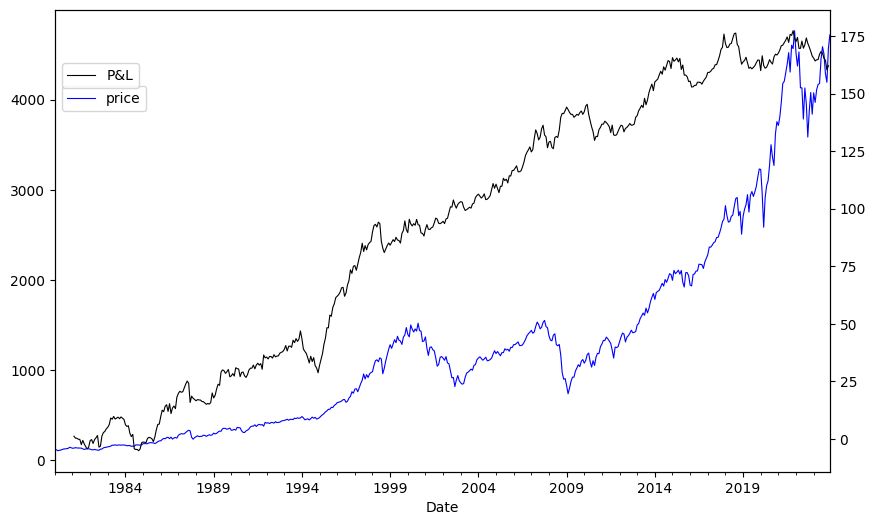

In [ ]:
plt.figure(figsize=(10,6))
ax1 = df["price"].plot(label="price", color="blue",linestyle="-",linewidth=0.8)
ax1.legend(loc="upper left",bbox_to_anchor=(0, 0.85))
ax2 = ax1.twinx()
df["Q"].plot(ax=ax2,label="P&L",color = "black",linestyle="-",linewidth=0.8)
ax2.legend(loc="upper left",bbox_to_anchor=(0, 0.9))

#Sharpe Ratio

In [ ]:
result = df["Q"].resample('Y').agg(['first','last','std']).dropna()
print("average sharpe ratio of SPX :",np.mean((result["last"]-result["first"])/result["std"]))

average sharpe ratio of SPX : 0.9694803574643105
